This notebook is used to identify domains using DeepST

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
os.chdir('/home/sergio/DeepST/DeepST-main/deepst')
import os 
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc

/home/sergio/anaconda3/envs/deepst_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.chdir('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/notebooks/architecture_exploration')

In [5]:
deepen = run(save_path = save_path,task = "Identify_Domain", pre_epochs = 800, epochs = 1000, use_gpu = True)

/home/sergio/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
adata=sc.read('../../data/processed_adata/adata_multisection_nuclei_r1_with_annotations.h5ad')
adata.X=adata.layers['raw']
adata=adata[adata.obs['replicate']=='1']

In [30]:
adata.obsm['spatial']=np.array(adata.obs.loc[:,['x_centroid','y_centroid']])

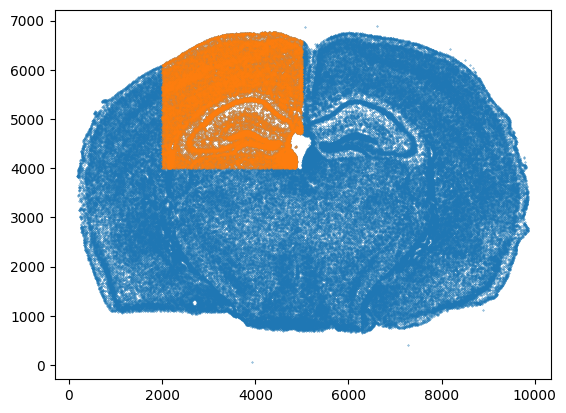

In [32]:
adata2=adata[(adata.obs['x_centroid']<5000)&(adata.obs['x_centroid']>2000)&(adata.obs['y_centroid']>4000)]
plt.scatter(adata.obs.loc[:,'x_centroid'],adata.obs.loc[:,'y_centroid'],s=0.1)
plt.scatter(adata2.obs.loc[:,'x_centroid'],adata2.obs.loc[:,'y_centroid'],s=0.1)
adata=adata2

In [56]:
ndoms=[]
for num in range(1,5):
    ndoms.append(len(np.unique(adata.obs['region_level'+str(num)])))

In [46]:
adata = deepen._get_augment(adata, spatial_type="BallTree", use_morphological=False)
###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!


In [47]:

data = deepen._data_process(adata, pca_n_comps = 200)

In [ ]:
deepst_embed = deepen._fit(data = data,graph_dict = graph_dict,)

Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████████████████████████████████████████████████████████ [ time left: 00:00 ]
/home/sergio/anaconda3/envs/deepst_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergio/anaconda3/envs/deepst_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-b

Best resolution:  0.1


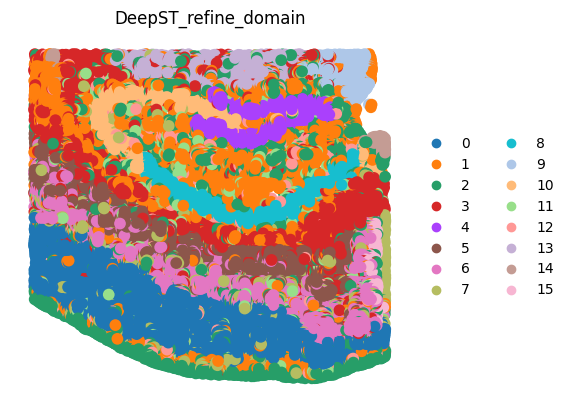

Best resolution:  0.1


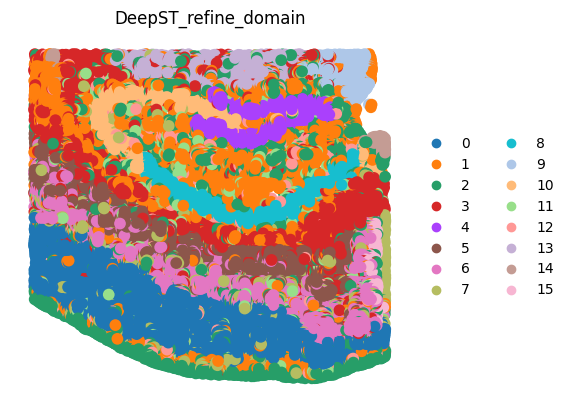

Best resolution:  0.13


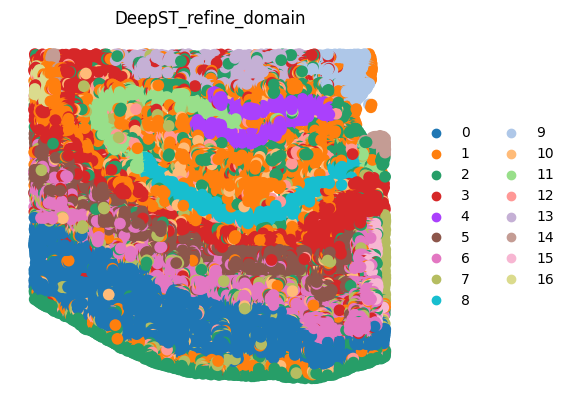

Best resolution:  1.7699999999999994


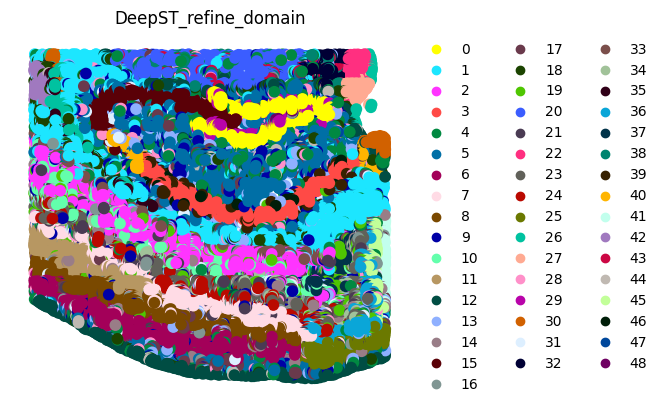

In [57]:
adata.obsm["DeepST_embed"] = deepst_embed
for n_domains in ndoms:
    ###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
    adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)
    ###### Spatial localization map of the spatial domain
    sc.pl.spatial(adata, color='DeepST_refine_domain', frameon = False, spot_size=100)
    #plt.savefig(os.path.join(save_path, f'{data_name}_domains.pdf'), bbox_inches='tight', dpi=300)
    results=adata.obs.loc[:,['cell_id','DeepST_refine_domain']]
    results.columns=['cell_id','spatial_domain']
    results.to_csv('../../figures/7.spatial_architecture/domains_predicted/ROI1/'+str(n_domains)+'/predicted_deepST.csv')